# Experiment 4: Binary Classification using Logistic Regression and SVM

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report

# Setup plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['savefig.dpi'] = 600

# Ensure plot directories exist
os.makedirs('../plots/png', exist_ok=True)
os.makedirs('../plots/eps', exist_ok=True)

def save_plot(filename):
    plt.savefig(f'../plots/png/{filename}.png', bbox_inches='tight')
    plt.savefig(f'../plots/eps/{filename}.eps', bbox_inches='tight', format='eps')
    print(f'Saved: {filename}')

## 2. Load Dataset

In [2]:
data_path = 'spambase_csv.csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nClass Distribution:")
print(df.iloc[:, -1].value_counts(normalize=True))

# Check for missing values
print("\nMissing values:", df.isnull().sum().sum())

Dataset Shape: (4601, 58)

First 5 rows:


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1



Class Distribution:
class
0    0.605955
1    0.394045
Name: proportion, dtype: float64

Missing values: 0


## 3. Data Preprocessing

In [3]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Set Shape:", X_train_scaled.shape)
print("Test Set Shape:", X_test_scaled.shape)

Training Set Shape: (3680, 57)
Test Set Shape: (921, 57)


## 4. Exploratory Data Analysis (EDA)

C:\Users\MONESH M\AppData\Local\Temp\ipykernel_32864\3617525341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


Saved: class_distribution


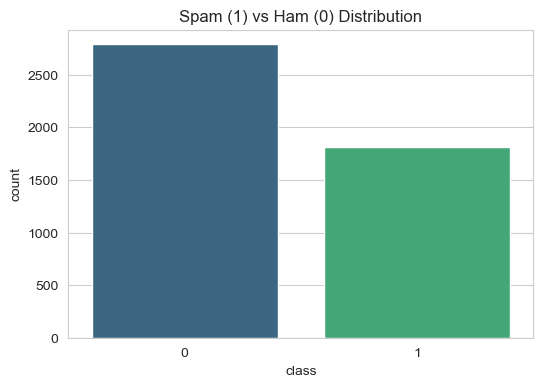

C:\Users\MONESH M\AppData\Local\Temp\ipykernel_32864\3617525341.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='magma')


Saved: feature_correlation


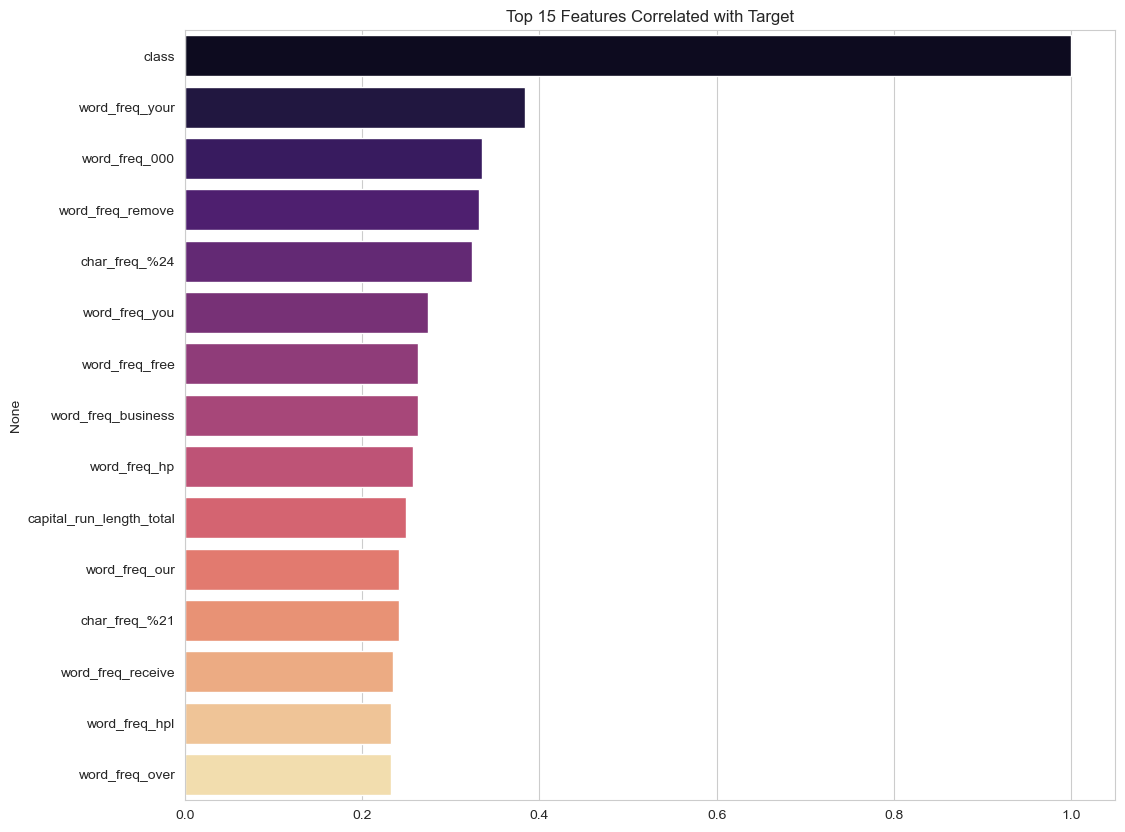

In [4]:
# Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title('Spam (1) vs Ham (0) Distribution')
save_plot('class_distribution')
plt.show()

# Top Correlated Features
plt.figure(figsize=(12, 10))
top_corr = df.corr().iloc[:, -1].abs().sort_values(ascending=False).head(15)
sns.barplot(x=top_corr.values, y=top_corr.index, palette='magma')
plt.title('Top 15 Features Correlated with Target')
save_plot('feature_correlation')
plt.show()

## 5. Logistic Regression

In [5]:
# Baseline Logistic Regression
log_reg = LogisticRegression(max_iter=5000)
start_time = time.time()
log_reg.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

y_pred = log_reg.predict(X_test_scaled)
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Hyperparameter Tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("Best LR Parameters:", grid_lr.best_params_)
print("Best LR CV Accuracy:", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

Baseline Logistic Regression Accuracy: 0.9294245385450597
Best LR Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best LR CV Accuracy: 0.9241847826086955


## 6. Support Vector Machine (SVM)

In [6]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_results = []

for kernel in kernels:
    start_time = time.time()
    model = SVC(kernel=kernel)
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    kernel_results.append({'Kernel': kernel, 'Accuracy': acc, 'F1': f1, 'Time': train_time})

rdf_kernels = pd.DataFrame(kernel_results)
print(rdf_kernels)

# Hyperparameter Tuning for SVM (RBF usually best)
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_scaled, y_train)

print("\nBest SVM Parameters:", grid_svc.best_params_)
print("Best SVM CV Accuracy:", grid_svc.best_score_)

best_svc = grid_svc.best_estimator_

    Kernel  Accuracy        F1      Time
0   linear  0.929425  0.909344  0.422344
1     poly  0.779587  0.621974  0.343136
2      rbf  0.927253  0.905501  0.201246
3  sigmoid  0.884908  0.852778  0.196516

Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM CV Accuracy: 0.9331521739130435


## 7. Model Evaluation & Comparison

--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       558
           1       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921

--- SVM (Best) Evaluation ---
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       558
           1       0.91      0.88      0.90       363

    accuracy                           0.92       921
   macro avg       0.92      0.91      0.92       921
weighted avg       0.92      0.92      0.92       921

Saved: confusion_matrices


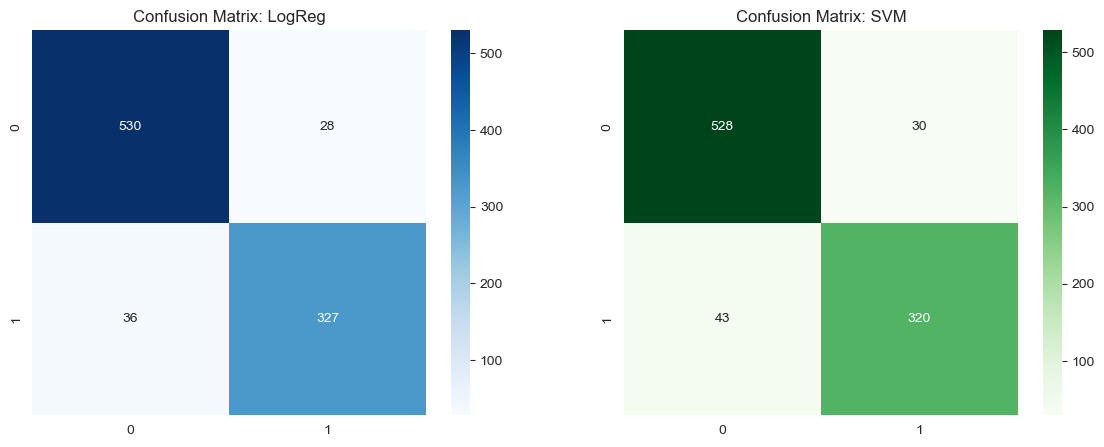

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved: roc_curve


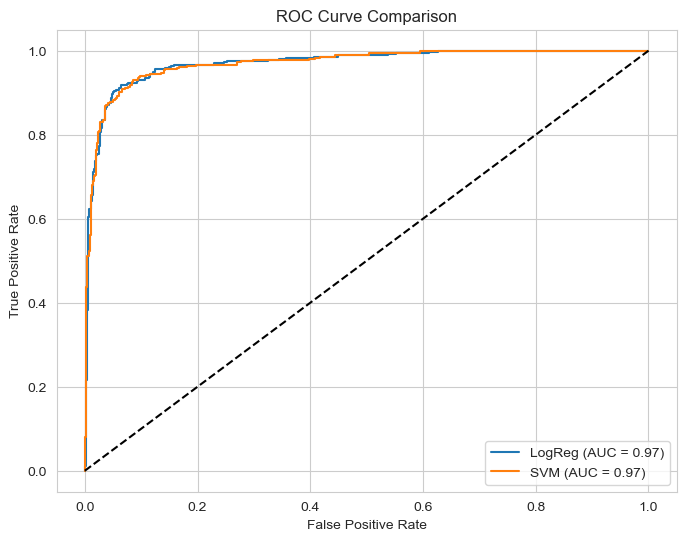

In [7]:
def evaluate_final(model, name, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    eval_time = time.time() - start_time
    
    print(f"--- {name} Evaluation ---")
    print(classification_report(y_test, y_pred))
    
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

lr_eval = evaluate_final(best_lr, "Logistic Regression", X_test_scaled, y_test)
svc_eval = evaluate_final(best_svc, "SVM (Best)", X_test_scaled, y_test)

# Confusion Matrix Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, best_lr.predict(X_test_scaled)), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix: LogReg')
sns.heatmap(confusion_matrix(y_test, best_svc.predict(X_test_scaled)), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Confusion Matrix: SVM')
save_plot('confusion_matrices')
plt.show()

# ROC Curve
lr_prob = best_lr.predict_proba(X_test_scaled)[:, 1]
try:
    svc_prob = best_svc.decision_function(X_test_scaled)
except:
    svc_prob = best_svc.predict_proba(X_test_scaled)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {auc(fpr_lr, tpr_lr):.2f})')
plt.plot(fpr_svc, tpr_svc, label=f'SVM (AUC = {auc(fpr_svc, tpr_svc):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
save_plot('roc_curve')
plt.show()

## 8. K-Fold Cross-Validation (K=5)

In [8]:
lr_cv = cross_val_score(best_lr, X_train_scaled, y_train, cv=5)
svc_cv = cross_val_score(best_svc, X_train_scaled, y_train, cv=5)

cv_results = pd.DataFrame({
    'Fold': [1, 2, 3, 4, 5],
    'Logistic Regression': lr_cv,
    'SVM': svc_cv
})

print(cv_results)
print("\nAverage LogReg CV Accuracy:", lr_cv.mean())
print("Average SVM CV Accuracy:", svc_cv.mean())

   Fold  Logistic Regression       SVM
0     1             0.940217  0.942935
1     2             0.914402  0.932065
2     3             0.922554  0.933424
3     4             0.915761  0.921196
4     5             0.927989  0.936141

Average LogReg CV Accuracy: 0.9241847826086955
Average SVM CV Accuracy: 0.9331521739130435


## 9. Learning Curves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved: learning_curves


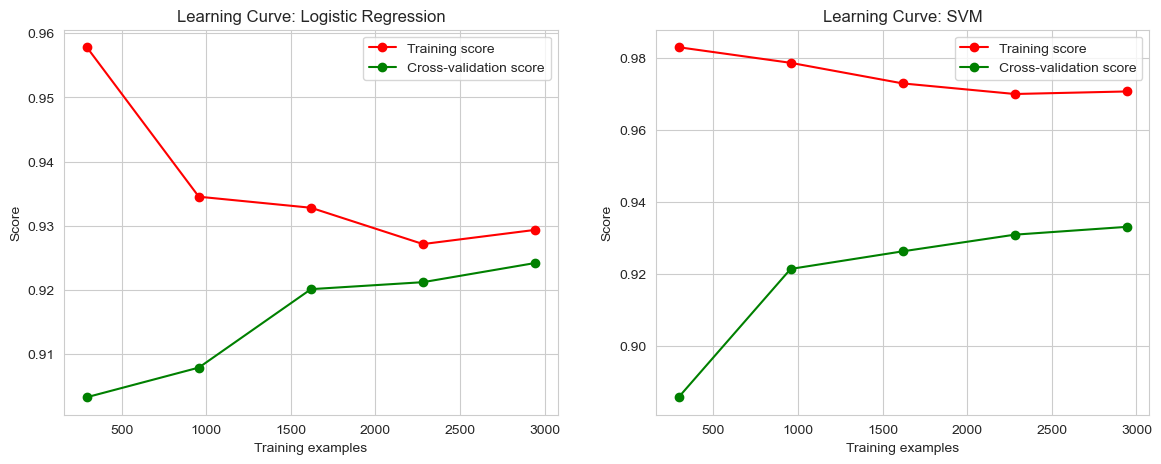

In [9]:
def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_learning_curve(best_lr, "Learning Curve: Logistic Regression", X_train_scaled, y_train)
plt.subplot(1, 2, 2)
plot_learning_curve(best_svc, "Learning Curve: SVM", X_train_scaled, y_train)
save_plot('learning_curves')
plt.show()